# Text Classification of StackOverflow using  Embeddings Centroids Vectors

In [1]:
import sys
import os
from os import pardir, getcwd
from os.path import join, abspath
PARENT_DIRECTORY = abspath(join(getcwd(), pardir))
sys.path.insert(0, PARENT_DIRECTORY)

import warnings
import sklearn.exceptions
import talos as ta
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from definitions import  TALOS_DIR
from app.preprocessing import load_dataset, load_embeddings, preprocess_data
from app.models import load_model, find_best_model_over_scan_logs


Using TensorFlow backend.


## Preprocessing for the loaded Dataset
1. Format into *lowercase*
2. Remove some of the *punctuation* characters
3. Remove *Numbers*
4. Remove *stopwords*
5. Remove *links*

In [3]:
data = load_dataset(load_from_pickle=True, input_ins='as_centroids')
Classes = list(data['tags'].value_counts().index)
Nclasses = len(Classes)
print(data['tags'].value_counts())

sql              2000
ruby-on-rails    2000
android          2000
angularjs        2000
asp.net          2000
c                2000
c#               2000
c++              2000
css              2000
html             2000
ios              2000
iphone           2000
java             2000
javascript       2000
jquery           2000
mysql            2000
objective-c      2000
php              2000
python           2000
.net             2000
Name: tags, dtype: int64


## MLP classifier in Keras using not standardized **embeddings-centroids** features

 ### Hyper parameter tuning for the  model

In [4]:
# 70% Train & 30% Test
# 70% Train-Dev % 30* Train-Dev 
embeddings = load_embeddings(data, 'post', minimized=False)
model_data_ftc = preprocess_data(data, 'tags', 'post',
                                 input_ins='as_centroids',
                                 cv_split_full=0.2,
                                 cv_split_dev=0.125,
                                 embeddings=embeddings)


In [10]:
TALOS_FTC_LOG_FILENAME = 'talos_ftc_log'
talos_ftc_log_pathname = os.path.join(TALOS_DIR, TALOS_FTC_LOG_FILENAME)


###### Production configuration
ftc_model_config = {
    'visualize_process': [True],
    'first_neuron': [256, 512],  # First Layer
    'activation': ['relu', 'tanh'],
    'dropout': [0.2, 0.6],
    'number_of_hidden_layers': [0, 1, 2],
    'shapes':['funnel'],
    'early_stopping_mode': [[0, 10]],
    'epochs': [20, 30],
    'early_stopping':[True],
    'early_stopping_config__monitor': ['val_f1'],
    'early_stopping_config__min_delta': [0],
    'early_stopping_config__patience': [5],
    'early_stopping_config__mode': ['max'],
    'batch_size': [32, 64],
    'model_type': ['keras_embeddings_centroids_model'],
}

history_model_ftc = ta.Scan(model_data_ftc['x_train'],
                            model_data_ftc['y_train'],
                            x_val=model_data_ftc['x_train_dev'],
                            y_val=model_data_ftc['y_train_dev'],
                            model=load_model,
                            params=ftc_model_config,
                            grid_downsample=0.05,
                            print_params=True,
                            last_epoch_value=True,
                            seed=(123),
                            dataset_name=talos_ftc_log_pathname
                            )





  0%|          | 0/4 [00:00<?, ?it/s]

{'visualize_process': True, 'first_neuron': 512, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'early_stopping_mode': [0, 10], 'epochs': 20, 'batch_size': 32, 'model_type': 'keras_embeddings_centroids_model'}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               154112    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_______________________


Epoch 00001: val_f1 improved from -inf to 0.44355, saving model to keras_embeddings_centroids_model



Epoch 00002: val_f1 improved from 0.44355 to 0.53502, saving model to keras_embeddings_centroids_model



Epoch 00003: val_f1 improved from 0.53502 to 0.57452, saving model to keras_embeddings_centroids_model



Epoch 00004: val_f1 improved from 0.57452 to 0.58923, saving model to keras_embeddings_centroids_model



Epoch 00005: val_f1 improved from 0.58923 to 0.63222, saving model to keras_embeddings_centroids_model



Epoch 00006: val_f1 did not improve from 0.63222



Epoch 00007: val_f1 improved from 0.63222 to 0.63301, saving model to keras_embeddings_centroids_model



Epoch 00008: val_f1 improved from 0.63301 to 0.63833, saving model to keras_embeddings_centroids_model



Epoch 00009: val_f1 did not improve from 0.63833



Epoch 00010: val_f1 improved from 0.63833 to 0.66175, saving model to keras_embeddings_centroids_model





 25%|██▌       | 1/4 [00:53<02:41, 53.73s/it]


Epoch 00011: val_f1 did not improve from 0.66175
{'visualize_process': True, 'first_neuron': 256, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'early_stopping_mode': [0, 10], 'epochs': 30, 'batch_size': 32, 'model_type': 'keras_embeddings_centroids_model'}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               77056     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)


Epoch 00001: val_f1 improved from -inf to 0.37004, saving model to keras_embeddings_centroids_model



Epoch 00002: val_f1 improved from 0.37004 to 0.51653, saving model to keras_embeddings_centroids_model



Epoch 00003: val_f1 improved from 0.51653 to 0.54185, saving model to keras_embeddings_centroids_model



Epoch 00004: val_f1 improved from 0.54185 to 0.58318, saving model to keras_embeddings_centroids_model



Epoch 00005: val_f1 improved from 0.58318 to 0.61027, saving model to keras_embeddings_centroids_model



Epoch 00006: val_f1 did not improve from 0.61027



Epoch 00007: val_f1 improved from 0.61027 to 0.61948, saving model to keras_embeddings_centroids_model



Epoch 00008: val_f1 improved from 0.61948 to 0.63089, saving model to keras_embeddings_centroids_model



Epoch 00009: val_f1 improved from 0.63089 to 0.64766, saving model to keras_embeddings_centroids_model



Epoch 00010: val_f1 improved from 0.64766 to 0.64905, saving model to keras_embeddings_centroids_model





 50%|█████     | 2/4 [01:28<01:35, 47.94s/it]


Epoch 00011: val_f1 did not improve from 0.64905
{'visualize_process': True, 'first_neuron': 256, 'activation': 'relu', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'early_stopping_mode': [0, 10], 'epochs': 20, 'batch_size': 64, 'model_type': 'keras_embeddings_centroids_model'}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               77056     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)


Epoch 00001: val_f1 improved from -inf to 0.26669, saving model to keras_embeddings_centroids_model



Epoch 00002: val_f1 improved from 0.26669 to 0.40823, saving model to keras_embeddings_centroids_model



Epoch 00003: val_f1 improved from 0.40823 to 0.47612, saving model to keras_embeddings_centroids_model



Epoch 00004: val_f1 improved from 0.47612 to 0.54035, saving model to keras_embeddings_centroids_model



Epoch 00005: val_f1 improved from 0.54035 to 0.56205, saving model to keras_embeddings_centroids_model



Epoch 00006: val_f1 improved from 0.56205 to 0.58775, saving model to keras_embeddings_centroids_model



Epoch 00007: val_f1 improved from 0.58775 to 0.61173, saving model to keras_embeddings_centroids_model



Epoch 00008: val_f1 improved from 0.61173 to 0.62741, saving model to keras_embeddings_centroids_model



Epoch 00009: val_f1 improved from 0.62741 to 0.62742, saving model to keras_embeddings_centroids_model



Epoch 00010: val_f1 did not improve from 0.62742





 75%|███████▌  | 3/4 [01:47<00:39, 39.40s/it]


Epoch 00011: val_f1 improved from 0.62742 to 0.64979, saving model to keras_embeddings_centroids_model
{'visualize_process': True, 'first_neuron': 256, 'activation': 'tanh', 'dropout': 0.6, 'number_of_hidden_layers': 0, 'shapes': 'funnel', 'early_stopping_mode': [0, 10], 'epochs': 30, 'batch_size': 32, 'model_type': 'keras_embeddings_centroids_model'}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               77056     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                5140      
Total params: 82,196
Trainable params: 82,196
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 did not improve from -inf



Epoch 00002: val_f1 improved from -inf to 0.31285, saving model to keras_embeddings_centroids_model



Epoch 00003: val_f1 improved from 0.31285 to 0.38496, saving model to keras_embeddings_centroids_model



Epoch 00004: val_f1 improved from 0.38496 to 0.44302, saving model to keras_embeddings_centroids_model



Epoch 00005: val_f1 improved from 0.44302 to 0.47899, saving model to keras_embeddings_centroids_model



Epoch 00006: val_f1 improved from 0.47899 to 0.51033, saving model to keras_embeddings_centroids_model



Epoch 00007: val_f1 improved from 0.51033 to 0.52582, saving model to keras_embeddings_centroids_model



Epoch 00008: val_f1 improved from 0.52582 to 0.55718, saving model to keras_embeddings_centroids_model



Epoch 00009: val_f1 improved from 0.55718 to 0.57081, saving model to keras_embeddings_centroids_model



Epoch 00010: val_f1 improved from 0.57081 to 0.57952, saving model to keras_embeddings_centroids_model



Epoch 00011: val_f1 improved from 0.57952 to 0.59471, saving model to keras_embeddings_centroids_model





100%|██████████| 4/4 [02:23<00:00, 38.32s/it]


Epoch 00012: val_f1 improved from 0.59471 to 0.59623, saving model to keras_embeddings_centroids_model


ValueError: Length mismatch: Expected axis has 18 elements, new values have 17 elements

    Finds the best model configuration set for the TF-IDF, after the Talos Scanning.

In [5]:
report_ftc = ta.Reporting(history_model_ftc)
best_model_idx = report_ftc.data['val_f1'].idxmax()
best_model_params = report_ftc.data.loc[best_model_idx].to_dict()
best_model_params

{'round_epochs': 3,
 'val_loss': 1.2104265446662903,
 'val_f1': 0.5793472619056702,
 'val_categorical_accuracy': 0.60875,
 'loss': 1.288303350346429,
 'f1': 0.5419161467211587,
 'categorical_accuracy': 0.5814285714285714,
 'visualize_process': 'False',
 'first_neuron': 512,
 'activation': 'tanh',
 'dropout': 0.2,
 'number_of_hidden_layers': 2,
 'shapes': 'funnel',
 'epochs': 30,
 'batch_size': 32,
 'model_type': 'keras_embeddings_centroids_model'}

    Train return a TF-IDF Model with the the best configuration set.

In [6]:
# Train and Load the best model of given the tuned featured model
best_model_params['visualize_process'] = True
model_ftc_history, model_ftc = load_model(model_data_ftc['x_train'],
                                          model_data_ftc['y_train'],
                                          model_data_ftc['x_train_dev'],
                                          model_data_ftc['y_train_dev'],
                                          best_model_params)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               154112    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                2580      
Total para


Epoch 00001: val_f1 improved from -inf to 0.43605, saving model to keras_embeddings_centroids_model



Epoch 00002: val_f1 improved from 0.43605 to 0.54345, saving model to keras_embeddings_centroids_model



Epoch 00003: val_f1 improved from 0.54345 to 0.58355, saving model to keras_embeddings_centroids_model



### Visualize Model History Scores

In [7]:
from app.visualization import plot_history_metrics
import matplotlib.pylab as plt

%matplotlib inline
# plot_history_metrics(history_obj=model_ftc_history)
model_ftc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               154112    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                2580      
Total para

### Evaluate performance model

Evaluates the performance of the best trained model in the **test** dataset. 

In [8]:
scoref_ftc = model_ftc.evaluate(model_data_ftc['x_test'],
                               model_data_ftc['y_test'],
                               batch_size=best_model_params['batch_size'],
                               verbose=1)

print('\nTest f1: %.4f' % (scoref_ftc[1]))
print('\nTest categorical accuracy: %.4f'% (scoref_ftc[2]))

8000/8000 [==============================] - 0s 38us/step

Test f1: 0.5863

Test categorical accuracy: 0.6330


### Visualize Prediction Perfomance  model

--------------------------------------------------------------------------------
Accuracy Score: 63.30%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0      0.467     0.642     0.541       400
           1      0.741     0.652     0.694       400
           2      0.607     0.757     0.674       400
           3      0.588     0.578     0.583       400
           4      0.686     0.818     0.746       400
           5      0.427     0.490     0.456       400
           6      0.811     0.450     0.579       400
           7      0.704     0.840     0.766       400
           8      0.610     0.542     0.574       400
           9      0.503     0.557     0.529       400
          10      0.528     0.355     0.425       400
          11      0.571     0.613     0.591       400
       

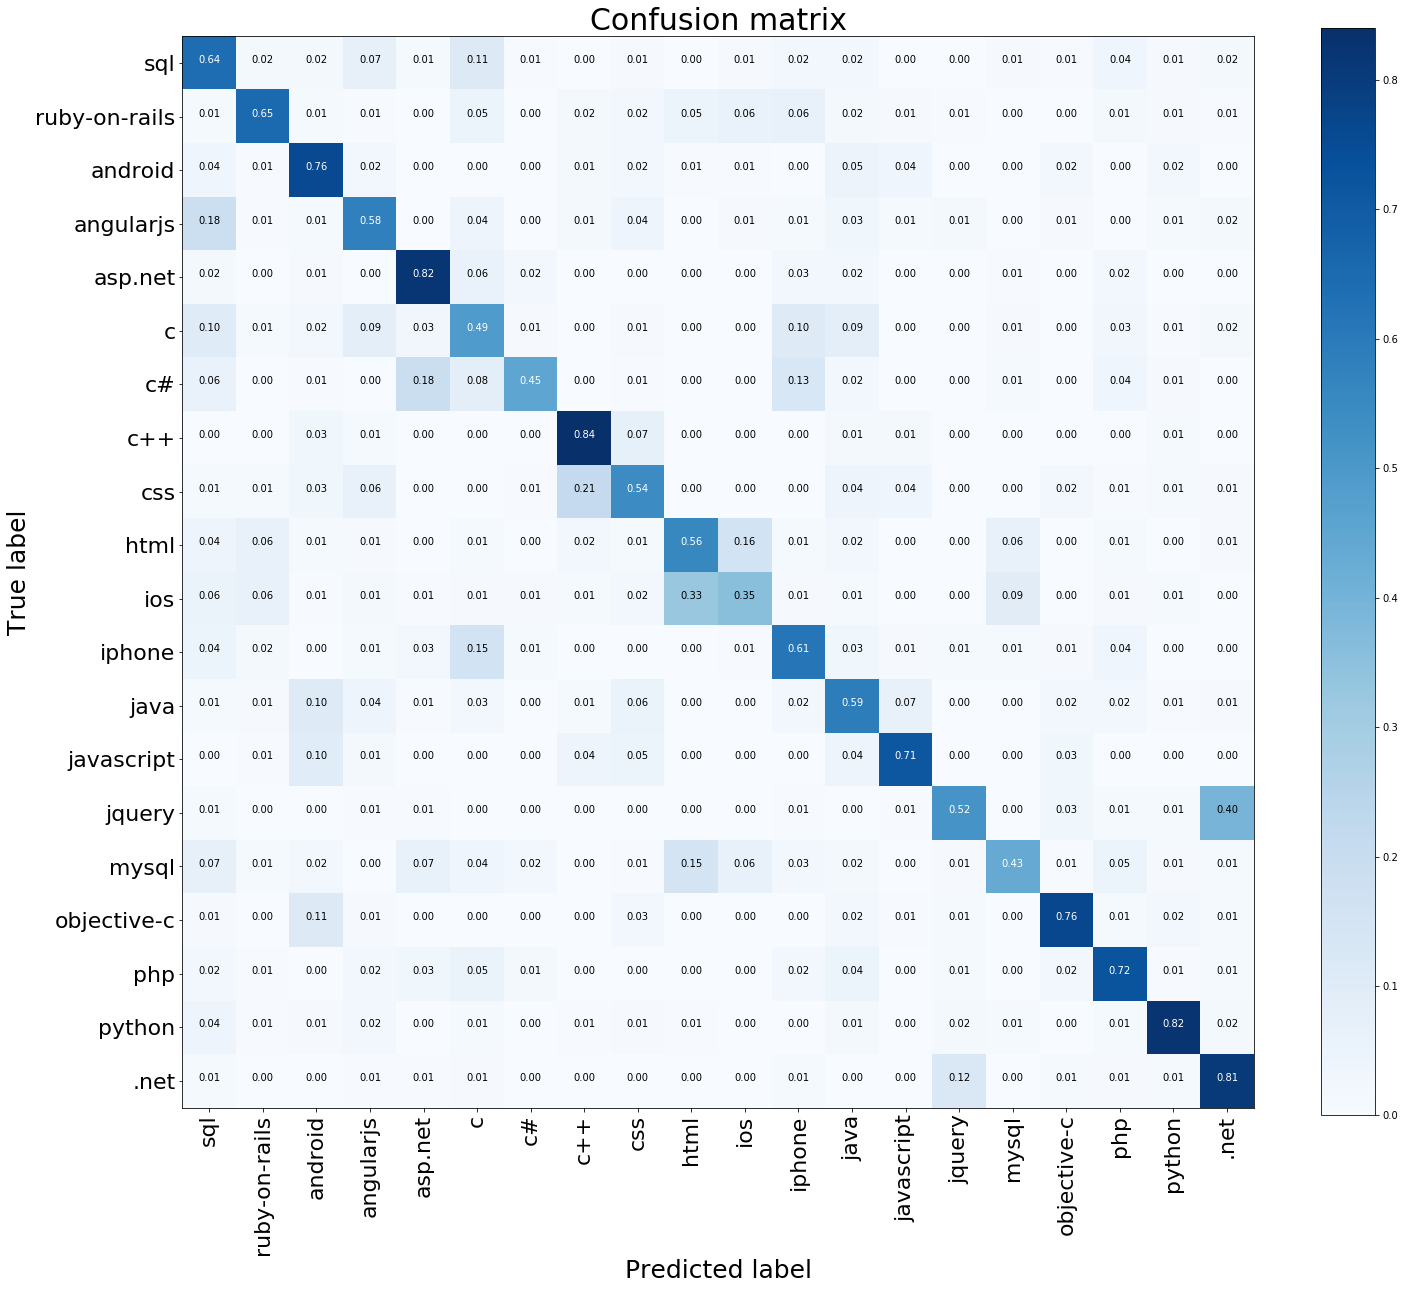

In [9]:
import numpy as np
from app.visualization import (plot_prediction_metrics,
                               create_clf_report,
                               plot_roc_curve,
                               plot_precision_recall_curve,
                               plot_confusion_matrix)
import matplotlib.pylab as plt

prediction_val_ftc = model_ftc.predict(model_data_ftc['x_test'], batch_size=best_model_params['batch_size'])

# returns each entry result to the classification with the relevant probabilities
y_pred_processed_ftc = np.array([np.argmax(val) for val in prediction_val_ftc])
y_true_processed_ftc = np.array([np.argmax(val) for val in model_data_ftc['y_test']])

# If you want to see the OneVSAll ROC Curves of each class uncomment the below line
# plot_roc_curve(model_data_ftc['y_test'], prediction_val_ftc, Classes, 1)

# If you want to see the OneVSAll Precission Recall Curves of each class, comment out the below line
# plot_precision_recall_curve(model_data_ftc['y_test'], prediction_val_ftc, Classes , 1)

# If you want to get the Classification Report, comment out the below line
create_clf_report(y_true_processed_ftc, y_pred_processed_ftc, Classes)

# If you want to get the confusion matrix,comment out the below line
plot_confusion_matrix(y_true_processed_ftc, y_pred_processed_ftc, Classes)

## MLP classifier in Keras using standardized **embeddings-centroids** features

In [10]:
TALOS_SDR_FTC_LOG_FILENAME = 'talos_sdr_ftc_log'
talos_sdr_ftc_log_pathname = os.path.join(TALOS_DIR, TALOS_SDR_FTC_LOG_FILENAME)
from app.models import load_model
    
# Loads the dataset using centroids embeddings but now every word vector has been stardirdized.
model_data_sdr_ftc = preprocess_data(data, 'tags', 'post',
                                     input_ins='as_centroids',
                                     cv_split_full=0.2,
                                     cv_split_dev=0.125,
                                     standardize=True,
                                     embeddings=embeddings)

In [11]:
ftc_sdr_model_config = ftc_model_config.copy()
ftc_sdr_model_config.update({
    'model_type': ['keras_sdr_embeddings_centroids_model']
})



history_model_sdr_ftc = ta.Scan(model_data_sdr_ftc['x_train'],
                                model_data_sdr_ftc['y_train'],
                                x_val=model_data_sdr_ftc['x_train_dev'],
                                y_val=model_data_sdr_ftc['y_train_dev'],
                                model=load_model,
                                params=ftc_sdr_model_config,
                                last_epoch_value=True,
                                grid_downsample=0.02,
                                print_params=True,
                                seed=123,
                                )

  0%|          | 0/1 [00:00<?, ?it/s]

{'visualize_process': False, 'first_neuron': 512, 'activation': 'relu', 'dropout': 0.2, 'number_of_hidden_layers': 0, 'shapes': 'funnel', 'epochs': 20, 'batch_size': 64, 'model_type': 'keras_sdr_embeddings_centroids_model'}


100%|██████████| 1/1 [00:06<00:00,  6.47s/it]


    Finds the best model for the Standardized FastText Embeddings Centroids.

In [12]:
report_sdr_ftc = ta.Reporting(history_model_sdr_ftc)

#get best model configuration
best_model_sdr_ftc_idx = report_sdr_ftc.data['val_f1'].idxmax()
best_model_params_sdr_ftc = report_sdr_ftc.data.loc[best_model_sdr_ftc_idx].to_dict()
best_model_params_sdr_ftc

{'round_epochs': 3,
 'val_loss': 1.060256859779358,
 'val_f1': 0.6472181425094604,
 'val_categorical_accuracy': 0.664,
 'loss': 1.061989319392613,
 'f1': 0.642263438974108,
 'categorical_accuracy': 0.6616785714285714,
 'visualize_process': 'False',
 'first_neuron': 512,
 'activation': 'relu',
 'dropout': 0.2,
 'number_of_hidden_layers': 0,
 'shapes': 'funnel',
 'epochs': 20,
 'batch_size': 64,
 'model_type': 'keras_sdr_embeddings_centroids_model'}

    Trains and fit the MLP Network with the standardized data using the best selected features.

In [13]:
model_sdr_ftc_history, model_sdr_ftc = load_model(model_data_sdr_ftc['x_train'],
                                                  model_data_sdr_ftc['y_train'],
                                                  model_data_sdr_ftc['x_train_dev'],
                                                  model_data_sdr_ftc['y_train_dev'],
                                                  best_model_params_sdr_ftc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               154112    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                10260     
Total params: 164,372
Trainable params: 164,372
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.56741, saving model to keras_sdr_embeddings_centroids_model



Epoch 00002: val_f1 improved from 0.56741 to 0.61138, saving model to keras_sdr_embeddings_centroids_model



Epoch 00003: val_f1 improved from 0.61138 to 0.63676, saving model to keras_sdr_embeddings_centroids_model



 ### Visualize Model History Scores


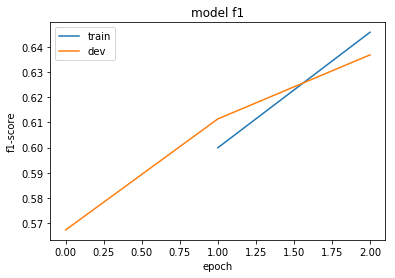

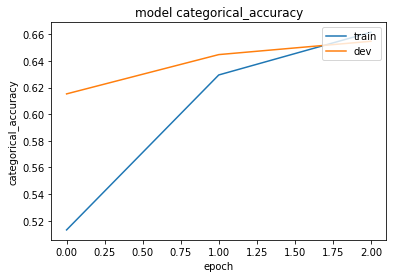

In [14]:
from app.visualization import plot_history_metrics
%matplotlib inline
plot_history_metrics(model_sdr_ftc_history)


### Evaluate performance model

Evaluates the performance of the best trained model in the **test** dataset. 

In [15]:
score_sdr_ftc = model_sdr_ftc.evaluate(model_data_sdr_ftc['x_test'],
                                       model_data_sdr_ftc['y_test'],
                                       batch_size=best_model_params_sdr_ftc['batch_size'],
                                       verbose=1)

print('\nTest f1: %.4f' % (score_sdr_ftc[1]))
print('\nTest categorical accuracy: %.4f'% (score_sdr_ftc[2]))

8000/8000 [==============================] - 0s 17us/step

Test f1: 0.6471

Test categorical accuracy: 0.6585


### Visualize Prediction Perfomance of standardized centroids MLP model

--------------------------------------------------------------------------------
Accuracy Score: 65.85%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0      0.617     0.535     0.573       400
           1      0.695     0.762     0.727       400
           2      0.486     0.757     0.592       400
           3      0.635     0.630     0.632       400
           4      0.714     0.830     0.768       400
           5      0.502     0.583     0.539       400
           6      0.801     0.585     0.676       400
           7      0.764     0.807     0.785       400
           8      0.621     0.455     0.525       400
           9      0.593     0.455     0.515       400
          10      0.514     0.497     0.506       400
          11      0.599     0.672     0.634       400
       

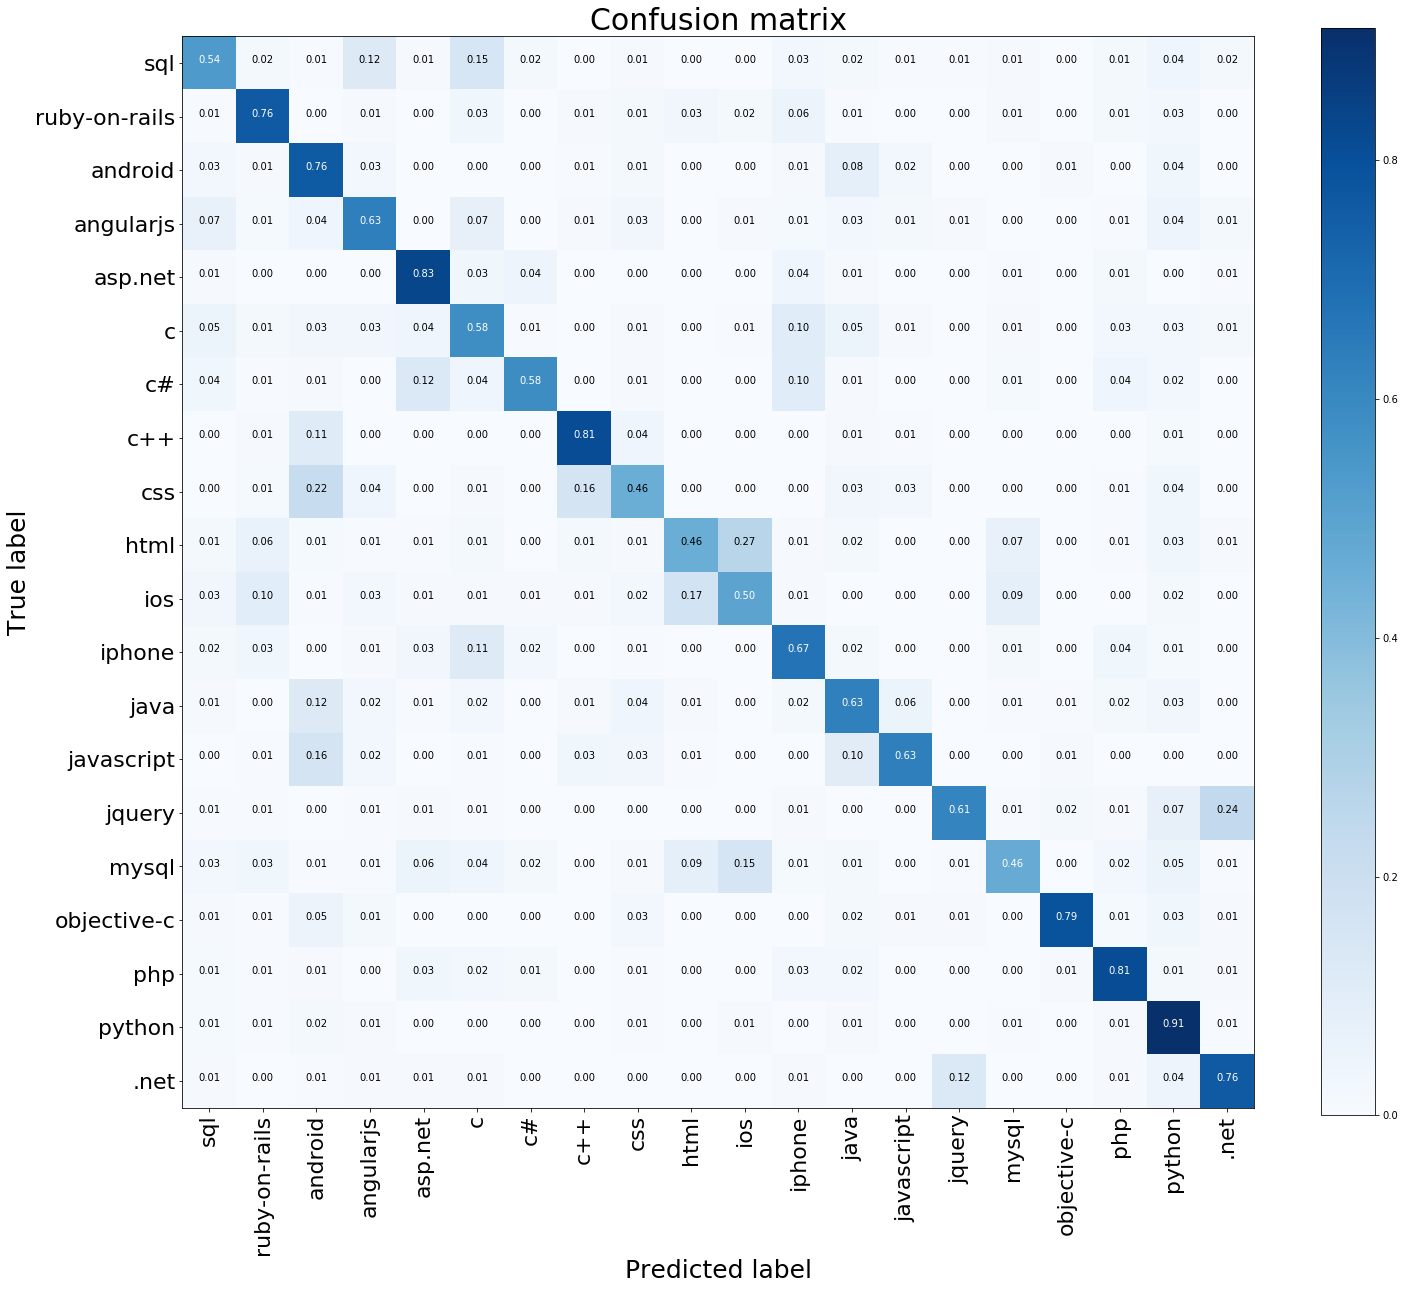

In [16]:
import numpy as np
from app.visualization import (plot_prediction_metrics,
                               create_clf_report,
                               plot_roc_curve,
                               plot_precision_recall_curve)
import matplotlib.pylab as plt

prediction_val_sdr_ftc = model_sdr_ftc.predict(model_data_sdr_ftc['x_test'],
                                               batch_size=best_model_params_sdr_ftc['batch_size'])

# returns each entry result to the classification with the relevant probabilities
y_pred_processed_sdr_ftc = np.array([np.argmax(val) for val in prediction_val_sdr_ftc])
y_true_processed_sdr_ftc = np.array([np.argmax(val) for val in model_data_sdr_ftc['y_test']])

# If you want to get the Classification Report, comment out the below line
create_clf_report(y_true_processed_sdr_ftc, y_pred_processed_sdr_ftc, Classes)

# If you want to get the confusion matrix,comment out the below line
plot_confusion_matrix(y_true_processed_sdr_ftc, y_pred_processed_sdr_ftc, Classes)